In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('https://bit.ly/wine_csv_data')
df.head()

,alcohol,sugar,pH,class
0,9.4,1.9,3.51,0.0
1,9.8,2.6,3.20,0.0
2,9.8,2.3,3.26,0.0
3,9.8,1.9,3.16,0.0
4,9.4,1.9,3.51,0.0


In [2]:
df.describe()

,alcohol,sugar,pH,class
count,6497.000000,6497.000000,6497.000000,6497.000000
mean,10.491801,5.443235,3.218501,0.753886
std,1.192712,4.757804,0.160787,0.430779
min,8.000000,0.600000,2.720000,0.000000
25%,9.500000,1.800000,3.110000,1.000000
50%,10.300000,3.000000,3.210000,1.000000
75%,11.300000,8.100000,3.320000,1.000000
max,14.900000,65.800000,4.010000,1.000000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   alcohol  6497 non-null   float64
 1   sugar    6497 non-null   float64
 2   pH       6497 non-null   float64
 3   class    6497 non-null   float64
dtypes: float64(4)
memory usage: 203.2 KB


## max_depth 테스트 세트를 이용한 성능 예측

#### 문제점

최적의 dept를 찾기 위해 테스트 세트를 여러번 이용하다 보면 결국 테스트 세트에 맞추게 되는 셈

테스트 세트 사용하지 않고 과대/과소적합 여부를 확인하기 위해 훈련세트를 나누게 된다 (**검증세트**)

In [4]:
data = df[['alcohol', 'sugar', 'pH']].to_numpy()
target = df['class'].to_numpy()

In [5]:
from sklearn.model_selection import train_test_split

train_input, test_input, train_target, test_target = train_test_split(data, target, test_size = 0.2, random_state=42)

In [6]:
sub_input, val_input, sub_target, val_target = train_test_split(train_input, train_target, test_size = 0.2, random_state=42)

In [7]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(sub_input, sub_target)
dt.score(sub_input, sub_target)

0.9971133028626413

In [8]:
dt.score(val_input, val_target)
#훈련세트에 과대적합됨

0.864423076923077

## 교차 검증

검증 세트를 떼어 내어 평가하는 과정을 여러번 반복 ex)k-폴드 교차 검증
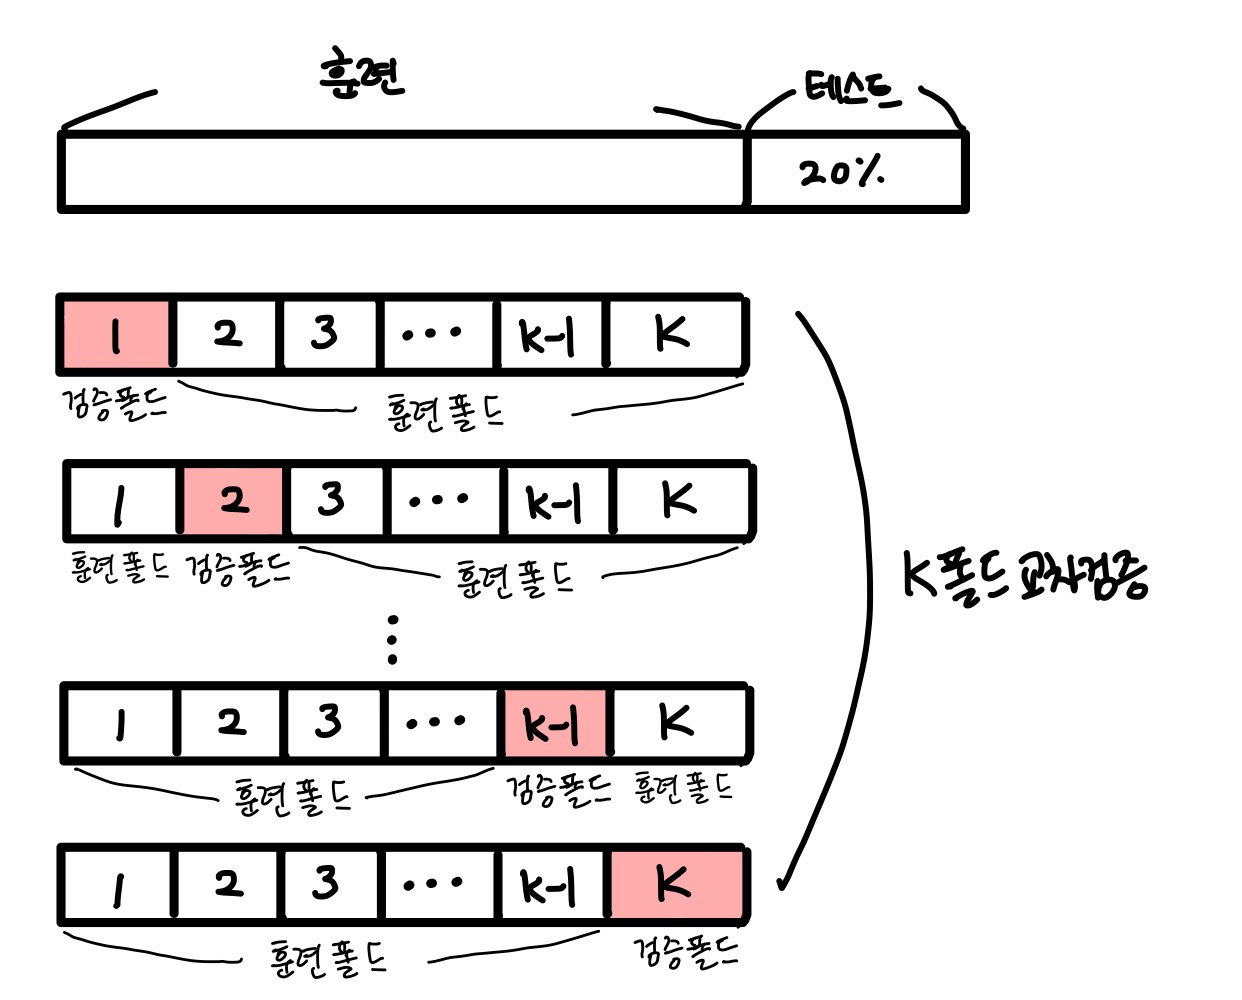

In [15]:
from sklearn.model_selection import cross_validate

scores = cross_validate(dt, train_input, train_target)
print(scores)

#5-폴드 교차 검증 (기본)

{'fit_time': array([0.00853086, 0.00522208, 0.00471497, 0.00446153, 0.00458097]), 'score_time': array([0.00109458, 0.00104499, 0.00110865, 0.00110555, 0.        ]), 'test_score': array([0.86923077, 0.84615385, 0.87680462, 0.84889317, 0.83541867])}


In [16]:
np.mean(scores['test_score'])
#검증 폴드의 점수

0.855300214703487

In [20]:
from sklearn.model_selection import StratifiedKFold

socres = cross_validate(dt, train_input, train_target)
np.mean(scores['test_score'])

0.855300214703487

In [24]:
splitter = StratifiedKFold(n_splits=10, shuffle = True, random_state = 42)
scores = cross_validate(dt, train_input, train_target, cv = splitter)
np.mean(scores['test_score'])

0.8574181117533719

In [25]:
from sklearn.model_selection import GridSearchCV

params = {'min_impurity_decrease': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005]}

In [30]:
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1)

In [32]:
gs.fit(train_input, train_target)
dt = gs.best_estimator_
dt.score(train_input, train_target)

0.9615162593804117

In [34]:
gs.best_params_

{'min_impurity_decrease': 0.0001}

In [35]:
gs.cv_results_['mean_test_score']

array([0.86819297, 0.86453617, 0.86492226, 0.86780891, 0.86761605])

In [38]:
best_index = np.argmax(gs.cv_results_['mean_test_score'])
gs.cv_results_['params'][best_index]

{'min_impurity_decrease': 0.0001}

In [39]:
params = {'min_impurity_decrease': np.arange(0.0001, 0.001, 0.0001),
         'max_depth': range(5, 20, 1),
         'min_samples_split': range(2,100,10)}

In [40]:
gs = GridSearchCV(DecisionTreeClassifier(random_state = 42), params, n_jobs=-1)
gs.fit(train_input, train_target)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(5, 20),
                         'min_impurity_decrease': array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009]),
                         'min_samples_split': range(2, 100, 10)})

In [41]:
gs.best_params_

{'max_depth': 14, 'min_impurity_decrease': 0.0004, 'min_samples_split': 12}

In [42]:
np.max(gs.cv_results_['mean_test_score'])

0.8683865773302731

### 랜덤 서치

In [45]:
from scipy.stats import uniform , randint

rgen = randint(0,10)
rgen.rvs(10)

array([6, 5, 0, 2, 6, 0, 7, 5, 3, 2], dtype=int64)

In [48]:
np.unique(rgen.rvs(1000), return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64),
 array([ 96, 102, 102,  88, 105,  98, 104,  96, 107, 102], dtype=int64))

In [49]:
ugen = uniform(0,10)
ugen.rvs(10)

array([3.31626761, 0.50130652, 5.78120056, 1.9665512 , 1.87836618,
       1.7470586 , 0.70248512, 3.97509325, 7.86255974, 2.26967893])

In [51]:
params = {'min_impurity_decrease': uniform(0.0001, 0.001),
         'max_depth': randint(20, 50),
         'min_samples_split': randint(2, 25),
         'min_samples_leaf': randint(1,25)}

In [57]:
from sklearn.model_selection import RandomizedSearchCV

gs = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1, n_iter=100, random_state=42)
gs.fit(train_input, train_target)
gs.best_params_

{'max_depth': 39,
 'min_impurity_decrease': 0.00034102546602601173,
 'min_samples_leaf': 7,
 'min_samples_split': 13}

In [62]:
np.max(gs.cv_results_['mean_test_score'])

0.8695428296438884

In [63]:
dt = gs.best_estimator_

In [64]:
dt.score(test_input,  test_target)

0.86